Here's my PyTorch implementations of iPINN (inverse Physics-Informed Neural Network) from the tutorial https://towardsdatascience.com/inverse-physics-informed-neural-net-3b636efeb37e  

The original implementations, were crafted using TensorFlow and can be accessed at https://github.com/jmorrow1000/PINN-iPINN  


@software{wojtak_pinn_ipinn_2024,  
  title        = {PINN and iPINN for RLC Circuit Equation in Pytorch},  
  author       = {Weronika Wojtak},  
  month        = feb,  
  year         = 2024,  
  version      = {1.0},  
  publisher    = {GitHub},  
  repository   = {https://github.com/w-wojtak/PINNs-and-iPINNs-Pytorch},  
}  


In [2]:
import datetime
import os

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
dirs = ['./model', './data', './figures']
for dir in dirs:
    if not os.path.exists(dir):
        os.makedirs(dir)

# upload the files to data folder

------------------------Neural network------------------------------------
NeuralNetwork(
  (activation_function): GELU(approximate='none')
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
----------------------------Optimizer--------------------------------------
LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 0.01
    max_eval: 25
    max_iter: 20
    tolerance_change: 1e-09
    tolerance_grad: 1e-07
)
------------------------Start training:2024-02-22 17:14:53---------------------
Running:  0  /  5000      loss:  10705.754
Running:  100  /  5000      loss:  0.0008623292
Running:  200  /  5000      loss:  0.00027117538
Running:  300  /  5000      loss:  0.00027135192
Running:  400  /  5000      loss:  0.00027147745
Running:  

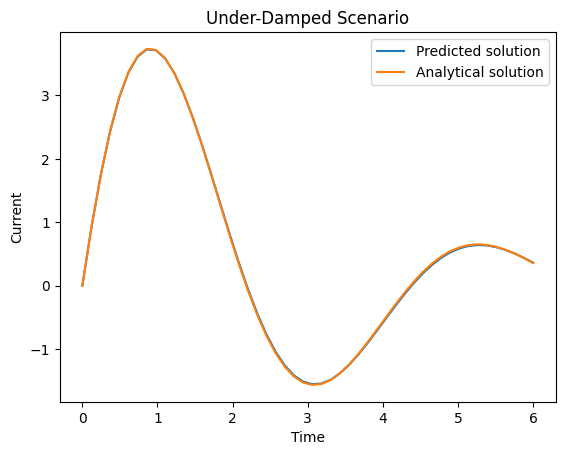

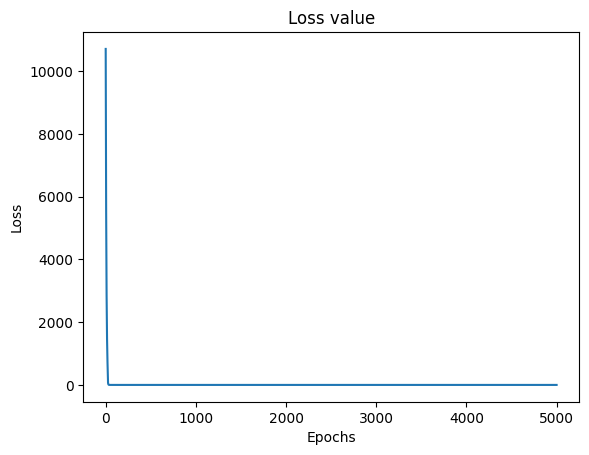

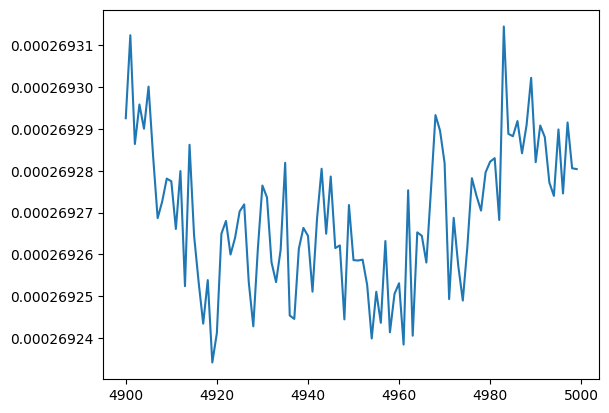

In [4]:
def main():

    scenario = 0 # 0: under-damped, 1: critically-damped, 2: over-damped

    # Load data
    base_filename = './data/pinn_data'

    # Determine the filename based on the scenario
    if scenario == 0:
        filename = base_filename + '_under-damped.pt'
    elif scenario == 1:
        filename = base_filename + '_critically-damped.pt'
    elif scenario == 2:
        filename = base_filename + '_over-damped.pt'
    else:
        raise ValueError("Invalid scenario value. Scenario should be 0, 1, or 2.")

    # Load the tensor from the file
    pinn_data = torch.load(filename)

    # Extract t_f and u_test_pred from the loaded tensor
    t_f, u_test_pred = pinn_data[:, 0], pinn_data[:, 1]

    # # If necessary, reshape them back to [N, 1]
    t_f = t_f.unsqueeze(1)
    u_test_pred = u_test_pred.unsqueeze(1)

    t_range = [0.0, 6.0]
    VC_0 = 12.0
    R, L, C = 0.1, 0.1, 0.1
    ode_parameters = [t_range, R, L, C, VC_0]

    # train parameters
    ni = 50
    optimizer = 0  # 0: L-BFGS 1: Adam 2: SGD
    max_epochs = 5000
    min_loss = 1e-8
    learning_rate = 0.01
    train_parameters = [scenario, ni, optimizer, max_epochs, min_loss, learning_rate]

    # test parameters
    test_parameters = [scenario, ni]

    # Neural networks parameters
    nn_layers = [1, 128, 128, 1]  # neural networks layers
    act_fun = 'gelu'
    nn_parameters = [nn_layers, act_fun]

    train(ode_parameters, train_parameters, nn_parameters, t_f, u_test_pred)  # train the model
    # test(ode_parameters, test_parameters) # test the model


class NeuralNetwork(nn.Module):
    def __init__(self, parameters):
        super(NeuralNetwork, self).__init__()
        [nn_layers, act_fun] = parameters

        # Define a dictionary for activation functions
        af_list = {
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'relu': nn.ReLU(),
            'gelu': nn.GELU()
        }
        self.activation_function = af_list.get(act_fun, None)

        # Check if activation function is provided
        if self.activation_function is None:
            raise ValueError(f"Activation function '{act_fun}' is not supported.")

        # Create layers dynamically based on nn_layers
        self.layers = nn.ModuleList()
        for i in range(len(nn_layers) - 1):
            self.layers.append(nn.Linear(nn_layers[i], nn_layers[i + 1]))
            if i < len(nn_layers) - 2:  # No activation function after the last layer
                self.layers.append(self.activation_function)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def pred(net_model, t):
    model_return = net_model(t)
    return model_return

def squared_difference(input, target):
    return (input - target) ** 2

def calculate_analytical_solution(ode_parameters, scenario, ni):
    t_range, _, _, _, VC_0 = ode_parameters

    i_calc = np.zeros(ni)
    t_test = np.linspace(t_range[0], t_range[1], ni)

    if scenario == 0:  # under-damped
        R = 1.2   # resistance, ohm
        L = 1.5   # inductance, H
        C = 0.3   # capacitance, F
        VC_0 = 12.0  # volts, initial capacitor voltage
    elif scenario == 1:  # critically-damped
        R = 4.47  # resistance, ohm
        L = 1.5   # inductance, H
        C = 0.3   # capacitance, F
        VC_0 = 12.0  # volts, initial capacitor voltage
    elif scenario == 2:  # over-damped
        R = 6.0   # resistance, ohm
        L = 1.5   # inductance, H
        C = 0.3   # capacitance, F
        VC_0 = 12.0  # volts, initial capacitor voltage
    else:
        raise ValueError("Invalid scenario value. Scenario should be 0 (under-damped), 1 (critically-damped), or 2 (over-damped).")

    alpha = R / (2 * L)

    for i in range(ni):
        if scenario == 0:  # under-damped
            i_calc[i] = 5.57 * np.exp(-0.4 * t_test[i]) * np.sin(1.44 * t_test[i])
        elif scenario == 1:  # critically-damped
            i_calc[i] = (VC_0 / L) * t_test[i] * np.exp(-1 * alpha * t_test[i])
        elif scenario == 2:  # over-damped
            i_calc[i] = 3.0 * (np.exp(-0.67 * t_test[i]) - np.exp(-3.33 * t_test[i]))
        else:
            raise ValueError("Invalid scenario value. Scenario should be 0 (under-damped), 1 (critically-damped), or 2 (over-damped).")

    return t_test, i_calc


def get_plot_title(scenario):
    if scenario == 0:  # under-damped
        return "Under-Damped Scenario"
    elif scenario == 1:  # critically-damped
        return "Critically-Damped Scenario"
    elif scenario == 2:  # over-damped
        return "Over-Damped Scenario"
    else:
        raise ValueError("Invalid scenario value. Scenario should be 0 (under-damped), 1 (critically-damped), or 2 (over-damped).")


def train(ode_parameters, train_parameters, nn_parameters, t_f, u_test_pred):
    # loading parameters
    [scenario, ni, opt, max_epochs, min_loss, learning_rate] = train_parameters
    [t_range, R, L, C, VC_0] = ode_parameters

    # initial condition - same as for PINN
    u_0 = [0.0];
    t_i = torch.FloatTensor(np.array(t_range[0]).reshape(-1, 1))
    u_i = torch.FloatTensor(np.array(u_0).reshape(-1, 1))

    #  f'(t) initial conditions - same as for PINN
    u_i2 = torch.FloatTensor(np.array(VC_0).reshape(-1, 1))

    t_i.requires_grad = True
    t_f.requires_grad = True

    net_model = NeuralNetwork(nn_parameters)

    train_R = torch.nn.Parameter(torch.FloatTensor([R]), requires_grad=True)
    net_model.register_parameter('R', train_R)

    train_L = torch.nn.Parameter(torch.FloatTensor([L]), requires_grad=True)
    net_model.register_parameter('L', train_L)

    train_C = torch.nn.Parameter(torch.FloatTensor([C]), requires_grad=True)
    net_model.register_parameter('C', train_C)

    # choose optimizer
    if opt == 1:
        optimizer = torch.optim.Adam([{'params': net_model.parameters()}], lr=learning_rate)
    elif opt == 2:
        optimizer = torch.optim.SGD([{'params': net_model.parameters()}], lr=learning_rate)
    else:
        optimizer = torch.optim.LBFGS([{'params': net_model.parameters()}], lr=learning_rate)


    epoch = 0
    loss = 10
    loss_record = np.empty([0, 3])
    rlc_record = np.empty([0, 3])
    plt.ion()
    print('------------------------Neural network------------------------------------')
    print(net_model)
    print('----------------------------Optimizer--------------------------------------')
    print(optimizer)
    #  -----------   start training   ------------
    starttime_train = datetime.datetime.now()
    formatted_time = starttime_train.strftime("%Y-%m-%d %H:%M:%S")
    print('------------------------Start training:{}---------------------'.format(formatted_time))

    while epoch < max_epochs and loss > min_loss:
        def closure():

          # u_i refers to the initial condition, u_f to the solution
          u_i_pred = pred(net_model, t_i)
          u_f_pred = pred(net_model, t_f)

          u_i_pred_dt = torch.autograd.grad(u_i_pred.sum(), t_i, create_graph=True)[0]

          u_f_pred_dt = torch.autograd.grad(u_f_pred.sum(), t_f, create_graph=True)[0]
          u_f_pred_dtt = torch.autograd.grad(u_f_pred_dt.sum(), t_f, create_graph=True)[0]

          f = (train_L * u_f_pred_dtt) + (train_R * u_f_pred_dt) + (u_f_pred / train_C)

          # get the three loss components
          loss_1 = torch.mean(squared_difference(u_i_pred, u_i))
          loss_2 = torch.mean(squared_difference(f, torch.zeros_like(t_f)))
          loss_3 = torch.mean(squared_difference(u_i_pred_dt, (u_i2 / train_L)))
          loss_4 = torch.mean(squared_difference(u_f_pred, u_test_pred))

          loss_total = loss_1 + loss_2 + loss_3 + loss_4

          optimizer.zero_grad()
          loss_total.backward(retain_graph=True)
          return loss_total


        optimizer.step(closure)
        loss_value = closure().cpu().data.numpy()
        step_time = datetime.datetime.now() - starttime_train
        loss_record = np.append(loss_record, [[epoch, step_time.seconds + step_time.microseconds / 1000000, loss_value]],
                                axis=0)

        rlc_record = np.append(
            rlc_record,
            [[train_R.item(), train_L.item(), train_C.item()]],  # Convert to scalar values
            axis=0
        )

        if epoch % 100 == 0:
          print('Running: ', epoch, ' / ', max_epochs, '     loss: ', loss_value)

        if epoch == max_epochs - 1 or loss <= min_loss:
          print(f"Final values at epoch {epoch}: R = {train_R.item()}, L = {train_L.item()}, C = {train_C.item()}")


        epoch += 1

        _, i_calc = calculate_analytical_solution(ode_parameters, scenario, ni)


    endtime_train = datetime.datetime.now()
    print('---------------End training:{}---------------'.format(endtime_train))
    torch.save(net_model, './model/PINN.pkl')

    train_time = endtime_train - starttime_train
    print('---------------Training time:{}s---------------'.format(train_time.seconds + train_time.microseconds / 1e6))


    with torch.no_grad():
      trained_model = torch.load('./model/PINN.pkl')

      plot_title = get_plot_title(scenario)

      plt.clf()
      u_test_pred = pred(trained_model, t_f)
      plt.plot(t_f, u_test_pred, label='Predicted solution')
      plt.plot(t_f, i_calc, label='Analytical solution')
      plt.title(plot_title)
      plt.xlabel('Time')
      plt.ylabel('Current')
      plt.legend(loc='upper right')
      plt.pause(0.1)

      plt.ioff()
      plt.show()

      plt.figure()
      plt.plot(loss_record[:, 0], loss_record[:, 2])
      plt.title('Loss value')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.show()

      # plot the last 100 values of loss
      plt.figure()
      plt.plot(loss_record[-100:, 0], loss_record[-100:, 2])
      plt.show()


def test(ode_parameters, test_parameters):
  [t_range, R, L, C, VC_0] = ode_parameters
  [scenario, ni] = test_parameters

  trained_model = torch.load('./model/PINN.pkl')

  t_test, i_calc = calculate_analytical_solution(ode_parameters, scenario, ni)

  t_test_tens = torch.FloatTensor(np.linspace(t_range[0], t_range[1], ni, endpoint=True).reshape(-1, 1))

  with torch.no_grad():
    trained_model = torch.load('./model/PINN.pkl')

    plot_title = get_plot_title(scenario)

    plt.clf()
    u_test_pred = pred(trained_model, t_test_tens)
    plt.plot(t_test_tens, u_test_pred, label='Predicted solution')
    plt.plot(t_test, i_calc, label='Analytical solution')
    plt.title(plot_title)
    plt.xlabel('Time')
    plt.ylabel('Current')
    plt.legend(loc='upper right')
    plt.pause(0.1)



if __name__ == '__main__':
    main()
    pass